In [1]:
import os
import cv2
import glob
from glob import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from collections import defaultdict

Using TensorFlow backend.


In [2]:
def show(X):
    display(Image.fromarray(X))

In [3]:
train_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TRAIN_SEGPA_80_64.npy')
test_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TEST_SEGPA_80_64.npy')
train = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TRAIN.csv')
test = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TEST.csv')
test_id = test.image.values

In [5]:
test_stg2 = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/TEST_STG2.csv')
test_stg2_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/ALL_TEST_STG2_SEGPA_80_64.npy')
test_stg2_id = test_stg2.image.values

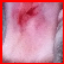

In [6]:
show(train_data[800])

In [7]:
train_data_ud = train_data[:,::-1,:,:]

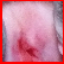

In [8]:
show(train_data_ud[800])

In [9]:
train_data_rl = train_data[:,:,::-1,:]

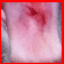

In [10]:
show(train_data_rl[800])

In [11]:
def rotation(image, angle):
    assert image.shape[-1] == 3
    num_rows, num_cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
    img_rotation = cv2.warpAffine(image, rotation_matrix, (num_cols, num_rows))
    return img_rotation

In [12]:
rot_num = 12
rot_imgs = defaultdict(list)
for i in range(train_data.shape[0]):
    for rot in range(int(360/rot_num),360,int(360/rot_num)):
        rot_img = rotation(train_data[i,:,:,:], rot)
        rot_imgs[rot].append(rot_img)

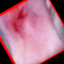

In [13]:
show(rot_imgs[30][800])

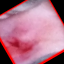

In [14]:
show(rot_imgs[120][800])

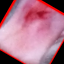

In [15]:
show(rot_imgs[330][800])

In [16]:
train_data = np.concatenate([train_data, train_data_ud, train_data_rl,\
                             np.array(rot_imgs[30]),np.array(rot_imgs[60]),\
                             np.array(rot_imgs[90]),np.array(rot_imgs[120]),\
                             np.array(rot_imgs[150]),np.array(rot_imgs[180]),\
                             np.array(rot_imgs[210]),np.array(rot_imgs[240]),\
                             np.array(rot_imgs[270]),np.array(rot_imgs[300]),\
                             np.array(rot_imgs[330])])

In [17]:
train_data.shape

(114968, 64, 64, 3)

### 增加亮度 

In [18]:
train_data_light = (train_data * 1.2).clip(0,255).astype(np.uint8)

In [19]:
train_data_light.shape

(114968, 64, 64, 3)

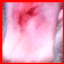

In [20]:
show(train_data_light[800])

### 減少亮度 

In [21]:
train_data_non_light = (train_data * 0.8).clip(0,255).astype(np.uint8)

In [22]:
train_data_non_light.shape

(114968, 64, 64, 3)

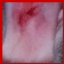

In [23]:
show(train_data_non_light[800])

### 組合

In [24]:
train_X = np.concatenate([train_data,train_data_light,train_data_non_light])

In [25]:
train_X.shape

(344904, 64, 64, 3)

In [26]:
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)
train_Y = np.concatenate([train_target for i in range(14*3)])

In [30]:
train_X.shape, train_Y.shape

((344904, 64, 64, 3), (344904,))

In [28]:
random_index = np.random.choice(range(train_X.shape[0]), train_X.shape[0], replace = False)

In [33]:
train_X = train_X[random_index]
train_Y = train_Y[random_index]

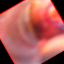

In [34]:
show(train_X[800])

In [35]:
x_train, x_val_train, y_train, y_val_train =\
train_test_split(train_X, train_Y, test_size = 0.1, random_state=17)

In [36]:
x_train.shape, x_val_train.shape, y_train.shape, y_val_train.shape

((310413, 64, 64, 3), (34491, 64, 64, 3), (310413,), (34491,))

In [37]:
train_X.shape

(344904, 64, 64, 3)

In [38]:
pwd

'/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/Final_Model'

In [67]:
#%timeit np.save('/home/Kaggle_Cervical_Cancer_Screening/Image_Data/Data_NOSEG_30W_Feature.npy', train_X)

In [68]:
#%timeit np.save('/home/Kaggle_Cervical_Cancer_Screening/Image_Data/Data_NOSEG_30W_Label.npy', train_Y)

In [39]:
# 3種 Type
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

In [40]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras import backend as K

In [41]:
model = Sequential()
model.add(Reshape((64,64,3), input_shape = x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), padding='same',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [42]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [43]:
x_train = x_train.astype('float32')
x_val_train = x_val_train.astype('float32')

x_train /= 255
x_val_train /= 255

x_test = test_data.astype('float32')
x_test /= 255

In [44]:
x_test_stg2= test_stg2_data.astype('float32')
x_test_stg2 /= 255

In [45]:
model.fit(x_train, y_train, validation_data = (x_val_train, y_val_train), epochs = 20, batch_size = 128)

Train on 310413 samples, validate on 34491 samples
Epoch 1/20
310413/310413 [==============================] - 103s - loss: 0.9930 - acc: 0.5297 - val_loss: 0.9465 - val_acc: 0.5372

In [46]:
pred = model.predict_proba(x_test)

416/512 [=======================>......] - ETA: 0s

In [47]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])
df['image_name'] = test_id
df = df[['image_name','Type_1','Type_2','Type_3']]

In [48]:
sample_submission =\
pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/sample_submission.csv')

In [49]:
for name in sample_submission['image_name']:
    #print(name)
    #sub[name] = df[df['image_name'] == name][['Type_1','Type_2','Type_3']].values.tolist()[0]
    #print(name)
    Type_1 = df.loc[df['image_name'] == name, 'Type_1']
    Type_2 = df.loc[df['image_name'] == name, 'Type_2']
    Type_3 = df.loc[df['image_name'] == name, 'Type_3']
    
    Type_1_index = Type_1.index[0]
    Type_2_index = Type_2.index[0]
    Type_3_index = Type_3.index[0]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_1'] = Type_1[Type_1_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_2'] = Type_2[Type_2_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_3'] = Type_3[Type_3_index]

In [50]:
sample_submission.head()

image_name    Type_1    Type_2    Type_3
0      0.jpg  0.007435  0.989769  0.002796
1      1.jpg  0.000762  0.087563  0.911675
2      2.jpg  0.998817  0.001167  0.000016
3      3.jpg  0.000164  0.786827  0.213008
4      4.jpg  0.000083  0.011437  0.988481

In [51]:
True_outcome = pd.read_csv('/home/dataset/solution_stg1_release.csv')

In [52]:
True_outcome.head()

image_name  Type_1  Type_2  Type_3
0      0.jpg       0       1       0
1      1.jpg       0       1       0
2      2.jpg       1       0       0
3      3.jpg       0       0       1
4      4.jpg       0       0       1

In [53]:
Pred = sample_submission[["Type_1","Type_2","Type_3"]].values

In [54]:
Ober = True_outcome[["Type_1","Type_2","Type_3"]].values

In [55]:
func = lambda y, p: y * np.log(max(min(p, 1-10e-15),10e-15))
log_loss = 0.0
for i in range(0, sample_submission.shape[0], 1):

    log_loss += np.sum(np.array(list(map(func, Ober[i], Pred[i]))))
    #print(log_loss)
log_loss /= (-1.) * sample_submission.shape[0]

In [56]:
log_loss

1.2372862649411869

In [57]:
pred_stg2 = model.predict_proba(x_test_stg2)
df_stg2 = pd.DataFrame(pred_stg2, columns=['Type_1','Type_2','Type_3'])
df_stg2['image_name'] = test_stg2_id
df_stg2 = df_stg2[['image_name','Type_1','Type_2','Type_3']]

3506/3506 [==============================] - 0s     


In [58]:
df_stg2.head()

image_name    Type_1    Type_2    Type_3
0  12708.jpg  0.000128  0.003966  0.995906
1  13284.jpg  0.000049  0.010507  0.989444
2  11551.jpg  0.003483  0.125896  0.870621
3  11151.jpg  0.000161  0.998832  0.001008
4  11643.jpg  0.990003  0.003876  0.006121

In [59]:
df_stg2.shape

(3506, 4)

In [ ]:
df_stg2_submission = pd.concat([sample_submission, df_stg2]).reset_index(drop=True)

In [ ]:
df_stg2_submission.to_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_SEG01_stg2.csv', index=False)

### Ensemble

In [99]:
df_stg2_submission01 = pd.read_csv("/home/Kaggle_Cervical_Cancer_Screening/submission/submission_LB01_stg2.csv")

In [100]:
df_stg2_submission02 = pd.read_csv("/home/Kaggle_Cervical_Cancer_Screening/submission/submission_SEG01_stg2.csv")

In [101]:
df_stg2_submission03 = pd.read_csv("/home/Kaggle_Cervical_Cancer_Screening/submission/submission_LB02_stg2.csv")

In [102]:
df_stg2_submission01.loc[:511,:]

image_name    Type_1    Type_2    Type_3
0        0.jpg  0.260129  0.554459  0.185412
1        1.jpg  0.052451  0.526170  0.421379
2        2.jpg  0.290795  0.634176  0.075029
3        3.jpg  0.063534  0.449358  0.487108
4        4.jpg  0.042226  0.319976  0.637798
5        5.jpg  0.220619  0.675406  0.103975
6        6.jpg  0.355308  0.553328  0.091364
7        7.jpg  0.067371  0.613552  0.319077
8        8.jpg  0.174622  0.546338  0.279041
9        9.jpg  0.201427  0.574215  0.224359
10      10.jpg  0.216031  0.694069  0.089900
11      11.jpg  0.052483  0.439257  0.508259
12      12.jpg  0.065845  0.312784  0.621371
13      13.jpg  0.101166  0.470271  0.428563
14      14.jpg  0.064916  0.457334  0.477750
15      15.jpg  0.056988  0.478018  0.464994
16      16.jpg  0.147115  0.462865  0.390020
17      17.jpg  0.205662  0.508760  0.285578
18      18.jpg  0.360695  0.572034  0.067271
19      19.jpg  0.042415  0.475572  0.482013
20      20.jpg  0.286475  0.649113  0.064412
21      21.jpg  0.202851  0.690946  0.106203
22      22.jpg  0.133802  0.549354  0.316844
23      23.jpg  0.083528  0.329465  0.587007
24      24.jpg  0.288404  0.619573  0.092024
25      25.jpg  0.139180  0.747990  0.112830
26      26.jpg  0.376766  0.531856  0.091378
27      27.jpg  0.095891  0.521936  0.382172
28      28.jpg  0.335846  0.566231  0.097923
29      29.jpg  0.046597  0.495696  0.457707
..         ...       ...       ...       ...
482    482.jpg  0.484279  0.450252  0.065469
483    483.jpg  0.247839  0.663986  0.088175
484    484.jpg  0.059195  0.425425  0.515380
485    485.jpg  0.101022  0.326432  0.572547
486    486.jpg  0.030910  0.323105  0.645985
487    487.jpg  0.200780  0.679892  0.119328
488    488.jpg  0.316234  0.416190  0.267575
489    489.jpg  0.154142  0.583357  0.262501
490    490.jpg  0.253620  0.588263  0.158117
491    491.jpg  0.044636  0.438840  0.516524
492    492.jpg  0.058016  0.508955  0.433030
493    493.jpg  0.145506  0.737455  0.117039
494    494.jpg  0.125260  0.748439  0.126301
495    495.jpg  0.086509  0.662816  0.250675
496    496.jpg  0.143836  0.260038  0.596126
497    497.jpg  0.102573  0.789929  0.107498
498    498.jpg  0.151371  0.484666  0.363963
499    499.jpg  0.074740  0.354144  0.571116
500    500.jpg  0.106282  0.532361  0.361357
501    501.jpg  0.211667  0.619760  0.168573
502    502.jpg  0.029223  0.387178  0.583600
503    503.jpg  0.064282  0.456175  0.479544
504    504.jpg  0.033951  0.246472  0.719578
505    505.jpg  0.131662  0.670361  0.197978
506    506.jpg  0.172786  0.630229  0.196984
507    507.jpg  0.121492  0.675438  0.203070
508    508.jpg  0.065923  0.391595  0.542482
509    509.jpg  0.103638  0.402597  0.493765
510    510.jpg  0.084111  0.544590  0.371299
511    511.jpg  0.064586  0.446975  0.488438

[512 rows x 4 columns]

In [103]:
df_stg2_submission02.loc[:511,:]

image_name    Type_1    Type_2        Type_3
0        0.jpg  0.007435  0.989769  2.795737e-03
1        1.jpg  0.000762  0.087563  9.116748e-01
2        2.jpg  0.998817  0.001167  1.644488e-05
3        3.jpg  0.000164  0.786827  2.130082e-01
4        4.jpg  0.000083  0.011437  9.884807e-01
5        5.jpg  0.003634  0.996365  1.417545e-07
6        6.jpg  0.000028  0.992927  7.044939e-03
7        7.jpg  0.253673  0.119484  6.268428e-01
8        8.jpg  0.000034  0.987650  1.231578e-02
9        9.jpg  0.011623  0.984765  3.612122e-03
10      10.jpg  0.391876  0.608095  2.892955e-05
11      11.jpg  0.000024  0.003995  9.959807e-01
12      12.jpg  0.000580  0.108578  8.908413e-01
13      13.jpg  0.000881  0.534806  4.643132e-01
14      14.jpg  0.001081  0.946187  5.273190e-02
15      15.jpg  0.007789  0.091553  9.006578e-01
16      16.jpg  0.003409  0.996589  1.738552e-06
17      17.jpg  0.675584  0.310253  1.416310e-02
18      18.jpg  0.099299  0.897668  3.032760e-03
19      19.jpg  0.000403  0.020323  9.792736e-01
20      20.jpg  0.965600  0.034354  4.557502e-05
21      21.jpg  0.002336  0.997661  3.537772e-06
22      22.jpg  0.006257  0.989343  4.399939e-03
23      23.jpg  0.502443  0.402827  9.473053e-02
24      24.jpg  0.003047  0.890699  1.062536e-01
25      25.jpg  0.106540  0.801939  9.152075e-02
26      26.jpg  0.000030  0.989736  1.023384e-02
27      27.jpg  0.070634  0.478456  4.509093e-01
28      28.jpg  0.548412  0.442681  8.906564e-03
29      29.jpg  0.000012  0.995960  4.027226e-03
..         ...       ...       ...           ...
482    482.jpg  0.999668  0.000332  3.028890e-07
483    483.jpg  0.028988  0.971008  4.580646e-06
484    484.jpg  0.004364  0.379424  6.162113e-01
485    485.jpg  0.000086  0.000221  9.996936e-01
486    486.jpg  0.000002  0.918798  8.120058e-02
487    487.jpg  0.335681  0.664305  1.408805e-05
488    488.jpg  0.000697  0.165433  8.338700e-01
489    489.jpg  0.994397  0.003910  1.692619e-03
490    490.jpg  0.061281  0.692587  2.461325e-01
491    491.jpg  0.002608  0.783819  2.135729e-01
492    492.jpg  0.001778  0.505039  4.931829e-01
493    493.jpg  0.031174  0.939567  2.925876e-02
494    494.jpg  0.000305  0.998192  1.503731e-03
495    495.jpg  0.000001  0.999895  1.043095e-04
496    496.jpg  0.155184  0.249405  5.954112e-01
497    497.jpg  0.189889  0.635868  1.742435e-01
498    498.jpg  0.732817  0.055125  2.120581e-01
499    499.jpg  0.004577  0.130535  8.648874e-01
500    500.jpg  0.090705  0.896490  1.280452e-02
501    501.jpg  0.019512  0.980394  9.379673e-05
502    502.jpg  0.054247  0.008145  9.376079e-01
503    503.jpg  0.000352  0.113621  8.860274e-01
504    504.jpg  0.002675  0.228898  7.684268e-01
505    505.jpg  0.000052  0.978979  2.096925e-02
506    506.jpg  0.000055  0.538606  4.613385e-01
507    507.jpg  0.001181  0.908610  9.020925e-02
508    508.jpg  0.000590  0.994856  4.554756e-03
509    509.jpg  0.005370  0.965269  2.936096e-02
510    510.jpg  0.000597  0.264350  7.350530e-01
511    511.jpg  0.000281  0.681964  3.177551e-01

[512 rows x 4 columns]

In [104]:
df_stg2_submission03.loc[:511,:]

image_name        Type_1    Type_2    Type_3
0        0.jpg  8.434056e-01  0.091033  0.065562
1        1.jpg  1.733882e-03  0.000496  0.997771
2        2.jpg  9.776188e-01  0.022364  0.000018
3        3.jpg  5.365233e-06  0.919446  0.080549
4        4.jpg  5.384965e-04  0.003351  0.996111
5        5.jpg  1.047801e-03  0.998932  0.000020
6        6.jpg  9.218731e-06  0.999988  0.000003
7        7.jpg  3.458519e-06  0.999888  0.000108
8        8.jpg  2.309569e-04  0.999716  0.000053
9        9.jpg  9.209505e-01  0.076222  0.002827
10      10.jpg  1.077797e-02  0.989190  0.000032
11      11.jpg  9.222679e-05  0.240857  0.759051
12      12.jpg  1.025607e-04  0.468522  0.531375
13      13.jpg  5.272319e-03  0.001495  0.993233
14      14.jpg  1.253299e-05  0.759515  0.240472
15      15.jpg  1.025839e-06  0.000888  0.999111
16      16.jpg  1.215643e-03  0.836712  0.162073
17      17.jpg  6.934555e-01  0.297944  0.008600
18      18.jpg  2.864537e-04  0.999712  0.000001
19      19.jpg  3.657414e-06  0.570868  0.429128
20      20.jpg  2.686607e-04  0.994895  0.004837
21      21.jpg  1.185346e-02  0.987653  0.000494
22      22.jpg  1.338878e-01  0.309478  0.556634
23      23.jpg  1.541429e-04  0.535403  0.464443
24      24.jpg  2.143179e-05  0.972986  0.026993
25      25.jpg  4.102468e-08  0.999991  0.000009
26      26.jpg  4.567765e-04  0.999537  0.000006
27      27.jpg  3.699301e-05  0.915070  0.084893
28      28.jpg  1.625862e-04  0.988589  0.011249
29      29.jpg  1.278966e-04  0.026974  0.972898
..         ...           ...       ...       ...
482    482.jpg  9.983266e-01  0.001641  0.000032
483    483.jpg  2.834816e-04  0.999161  0.000555
484    484.jpg  6.693091e-01  0.258265  0.072426
485    485.jpg  4.735855e-06  0.759847  0.240148
486    486.jpg  1.233806e-03  0.021896  0.976870
487    487.jpg  9.640887e-01  0.035906  0.000005
488    488.jpg  4.089929e-01  0.544017  0.046991
489    489.jpg  4.938104e-01  0.328424  0.177765
490    490.jpg  1.170999e-04  0.007170  0.992713
491    491.jpg  1.081626e-01  0.889805  0.002032
492    492.jpg  4.379315e-05  0.070234  0.929722
493    493.jpg  2.761561e-01  0.705257  0.018587
494    494.jpg  2.018534e-07  0.999992  0.000008
495    495.jpg  4.045937e-06  0.835372  0.164624
496    496.jpg  3.194313e-03  0.099901  0.896904
497    497.jpg  4.336105e-03  0.888892  0.106772
498    498.jpg  4.906422e-02  0.950240  0.000696
499    499.jpg  6.235948e-01  0.024610  0.351795
500    500.jpg  5.629749e-01  0.201148  0.235877
501    501.jpg  1.929875e-03  0.996157  0.001914
502    502.jpg  1.854164e-06  0.482343  0.517655
503    503.jpg  1.238381e-05  0.782340  0.217648
504    504.jpg  1.395646e-01  0.541065  0.319371
505    505.jpg  7.787587e-01  0.177968  0.043273
506    506.jpg  8.623314e-05  0.995556  0.004358
507    507.jpg  3.325113e-05  0.705748  0.294219
508    508.jpg  2.315139e-02  0.745192  0.231657
509    509.jpg  4.094931e-02  0.935611  0.023439
510    510.jpg  1.097752e-01  0.508007  0.382218
511    511.jpg  1.227108e-03  0.448822  0.549951

[512 rows x 4 columns]

In [95]:
True_outcome

image_name  Type_1  Type_2  Type_3
0        0.jpg       0       1       0
1        1.jpg       0       1       0
2        2.jpg       1       0       0
3        3.jpg       0       0       1
4        4.jpg       0       0       1
5        5.jpg       0       1       0
6        6.jpg       0       1       0
7        7.jpg       0       1       0
8        8.jpg       0       1       0
9        9.jpg       0       1       0
10      10.jpg       0       1       0
11      11.jpg       0       0       1
12      12.jpg       0       1       0
13      13.jpg       0       0       1
14      14.jpg       0       1       0
15      15.jpg       0       0       1
16      16.jpg       1       0       0
17      17.jpg       0       1       0
18      18.jpg       0       1       0
19      19.jpg       0       0       1
20      20.jpg       1       0       0
21      21.jpg       0       1       0
22      22.jpg       0       1       0
23      23.jpg       1       0       0
24      24.jpg       0       1       0
25      25.jpg       1       0       0
26      26.jpg       0       1       0
27      27.jpg       0       0       1
28      28.jpg       0       1       0
29      29.jpg       0       0       1
..         ...     ...     ...     ...
482    482.jpg       1       0       0
483    483.jpg       0       1       0
484    484.jpg       0       0       1
485    485.jpg       0       0       1
486    486.jpg       0       1       0
487    487.jpg       0       1       0
488    488.jpg       0       1       0
489    489.jpg       1       0       0
490    490.jpg       0       1       0
491    491.jpg       0       0       1
492    492.jpg       0       1       0
493    493.jpg       1       0       0
494    494.jpg       0       1       0
495    495.jpg       0       1       0
496    496.jpg       0       0       1
497    497.jpg       0       1       0
498    498.jpg       0       1       0
499    499.jpg       0       0       1
500    500.jpg       0       1       0
501    501.jpg       0       1       0
502    502.jpg       0       0       1
503    503.jpg       0       1       0
504    504.jpg       0       0       1
505    505.jpg       0       1       0
506    506.jpg       0       1       0
507    507.jpg       0       1       0
508    508.jpg       0       1       0
509    509.jpg       0       1       0
510    510.jpg       0       1       0
511    511.jpg       0       0       1

[512 rows x 4 columns]

In [111]:
df_ensemble = df_stg2_submission02
df_ensemble[['Type_1']] = (df_stg2_submission02[['Type_1']] + df_stg2_submission03[['Type_1']]) * 0.5
df_ensemble[['Type_2']] = (df_stg2_submission02[['Type_2']] + df_stg2_submission03[['Type_2']]) * 0.5
df_ensemble[['Type_3']] = (df_stg2_submission02[['Type_3']] + df_stg2_submission03[['Type_3']]) * 0.5

In [116]:
df_ensemble[['Type_1','Type_2','Type_3']].div(df_ensemble[['Type_1','Type_2','Type_3']].sum(axis=1), axis=0)

Type_1    Type_2    Type_3
0     0.697843  0.260940  0.041218
1     0.001829  0.022255  0.975917
2     0.984742  0.015242  0.000015
3     0.000026  0.886308  0.113666
4     0.000549  0.005371  0.994080
5     0.001502  0.998482  0.000015
6     0.000013  0.998224  0.001763
7     0.032751  0.805323  0.161926
8     0.000235  0.996646  0.003118
9     0.750663  0.246876  0.002460
10    0.062663  0.937304  0.000033
11    0.000095  0.181638  0.818267
12    0.000175  0.378554  0.621271
13    0.005376  0.134660  0.859964
14    0.000148  0.806289  0.193563
15    0.000976  0.023577  0.975447
16    0.001642  0.876788  0.121570
17    0.714383  0.276441  0.009175
18    0.012857  0.986374  0.000769
19    0.000054  0.433253  0.566693
20    0.137563  0.858298  0.004138
21    0.012113  0.987517  0.000370
22    0.130407  0.464267  0.405326
23    0.067176  0.535895  0.396929
24    0.000403  0.952772  0.046825
25    0.013497  0.963307  0.023196
26    0.000461  0.996976  0.002563
27    0.008945  0.813088  0.177967
28    0.073768  0.914785  0.011447
29    0.000129  0.269212  0.730658
...        ...       ...       ...
3988  0.995612  0.002696  0.001692
3989  0.001313  0.988057  0.010631
3990  0.996108  0.003043  0.000849
3991  0.004178  0.260789  0.735034
3992  0.011443  0.741053  0.247504
3993  0.015096  0.962860  0.022044
3994  0.995757  0.004013  0.000230
3995  0.000205  0.002964  0.996831
3996  0.014541  0.843674  0.141785
3997  0.000016  0.025929  0.974055
3998  0.000012  0.246843  0.753145
3999  0.000132  0.978292  0.021576
4000  0.673245  0.263787  0.062968
4001  0.000718  0.997461  0.001822
4002  0.001457  0.926820  0.071723
4003  0.012253  0.663458  0.324289
4004  0.067436  0.932484  0.000080
4005  0.004937  0.819986  0.175076
4006  0.030970  0.493844  0.475186
4007  0.000840  0.954277  0.044883
4008  0.525060  0.330116  0.144824
4009  0.656897  0.320600  0.022503
4010  0.083166  0.916772  0.000062
4011  0.022614  0.977379  0.000007
4012  0.008310  0.728037  0.263653
4013  0.001459  0.051727  0.946814
4014  0.000008  0.997911  0.002081
4015  0.007005  0.992602  0.000393
4016  0.004775  0.984753  0.010473
4017  0.006669  0.794313  0.199018

[4018 rows x 3 columns]

In [117]:
df_ensemble

image_name    Type_1    Type_2    Type_3
0         0.jpg  0.844335  0.315717  0.049870
1         1.jpg  0.001829  0.022262  0.976247
2         2.jpg  1.102471  0.017064  0.000017
3         3.jpg  0.000026  0.886291  0.113664
4         4.jpg  0.000549  0.005372  0.994203
5         5.jpg  0.001502  0.998290  0.000015
6         6.jpg  0.000013  0.998223  0.001763
7         7.jpg  0.031713  0.779787  0.156792
8         8.jpg  0.000235  0.996700  0.003119
9         9.jpg  0.922403  0.303358  0.003023
10       10.jpg  0.059763  0.893916  0.000031
11       11.jpg  0.000095  0.181641  0.818283
12       12.jpg  0.000175  0.378536  0.621242
13       13.jpg  0.005382  0.134823  0.861003
14       14.jpg  0.000148  0.806183  0.193537
15       15.jpg  0.000975  0.023554  0.974497
16       16.jpg  0.001642  0.876681  0.121555
17       17.jpg  0.777903  0.301021  0.009991
18       18.jpg  0.012699  0.974201  0.000759
19       19.jpg  0.000054  0.433232  0.566665
20       20.jpg  0.120969  0.754759  0.003639
21       21.jpg  0.012145  0.990155  0.000371
22       22.jpg  0.134670  0.479444  0.418576
23       23.jpg  0.062959  0.502259  0.372015
24       24.jpg  0.000402  0.952414  0.046808
25       25.jpg  0.013318  0.950478  0.022887
26       26.jpg  0.000461  0.997087  0.002563
27       27.jpg  0.008866  0.805917  0.176397
28       28.jpg  0.068714  0.852112  0.010663
29       29.jpg  0.000129  0.269221  0.730680
...         ...       ...       ...       ...
3988  11041.jpg  1.118471  0.003029  0.001900
3989  12018.jpg  0.001311  0.986762  0.010617
3990  12538.jpg  1.122806  0.003430  0.000957
3991  12506.jpg  0.004182  0.261060  0.735799
3992  13162.jpg  0.011422  0.739658  0.247038
3993  13262.jpg  0.015152  0.966453  0.022126
3994  13170.jpg  1.119491  0.004512  0.000258
3995  10325.jpg  0.000205  0.002964  0.996879
3996  10903.jpg  0.014338  0.831891  0.139805
3997  11486.jpg  0.000016  0.025928  0.974048
3998  10821.jpg  0.000012  0.246840  0.753136
3999  10062.jpg  0.000132  0.978166  0.021573
4000  11980.jpg  0.797789  0.312584  0.074617
4001  10217.jpg  0.000718  0.997512  0.001822
4002  12952.jpg  0.001455  0.925545  0.071625
4003  12008.jpg  0.012290  0.665462  0.325269
4004  10201.jpg  0.068506  0.947274  0.000081
4005  10006.jpg  0.004913  0.815960  0.174217
4006  13495.jpg  0.030429  0.485208  0.466877
4007  11911.jpg  0.000839  0.953540  0.044848
4008  13035.jpg  0.596706  0.375161  0.164586
4009  10208.jpg  0.785934  0.383577  0.026924
4010  11429.jpg  0.084423  0.930632  0.000063
4011  10835.jpg  0.022168  0.958093  0.000006
4012  10711.jpg  0.008289  0.726247  0.263005
4013  13036.jpg  0.001457  0.051665  0.945694
4014  11645.jpg  0.000008  0.997905  0.002081
4015  11970.jpg  0.007018  0.994329  0.000394
4016  12037.jpg  0.004761  0.981969  0.010443
4017  12936.jpg  0.006626  0.789144  0.197723

[4018 rows x 4 columns]

In [118]:
Pred = df_ensemble[["Type_1","Type_2","Type_3"]].values

In [119]:
True_outcome = pd.read_csv('/home/dataset/solution_stg1_release.csv')

In [120]:
func = lambda y, p: y * np.log(max(min(p, 1-10e-15),10e-15))
log_loss = 0.0
for i in range(0, sample_submission.shape[0], 1):

    log_loss += np.sum(np.array(list(map(func, Ober[i], Pred[i]))))
    #print(log_loss)
log_loss /= (-1.) * sample_submission.shape[0]

In [121]:
log_loss

1.063708318044251